In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report

In [2]:
seed = 45

In [57]:
data_category = pd.read_csv('info_category.csv', delimiter=';', decimal=".") 
print(data_category.shape)

(493, 4)


In [4]:
def prepare_data(file_name, data_category):
    data = pd.read_csv(file_name+'.csv', delimiter=';', decimal=".") 
    data = data_category.merge(data, left_on=['img_name','folder','image'], right_on=['img_name','folder','image'])
    data[['category']] =  data[['category']].abs()
    data = data[data.category>0]
    data[['category']] =  data[['category']]-1
    return data

In [5]:
def order_data(data):
    for index in data.index:
        #row = data.loc[index, :]
        #print(row.to_frame().T)
        for i in range(0,sections_width):
            sections_range = range(sections_heigth*i+1,sections_heigth*(i+1)+1)
            sections = data.loc[index, ['pw_'+str(i) for i in sections_range]]
            if sections[0]<5 and sections[1]<5:
                reverse = sections.iloc[::-1]
                data.loc[index, ['pw_'+str(i) for i in sections_range]] = reverse.values
        row = data.loc[index, :]

In [6]:
from sklearn.preprocessing import Normalizer
file_name = 'info_h_'+str(50)
sections_width = 50
data = prepare_data(file_name, data_category)
print("Distribuition of Normal(0) and Frauds(1): ")
print(data["category"].value_counts())
print('')

Distribuition of Normal(0) and Frauds(1): 
0    85
2    59
1    39
Name: category, dtype: int64



In [7]:
X_values = data[['h_'+str(i) for i in range(1,sections_width+1)]]
y_values = data[['category']]
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, random_state=0).fit(X_train)
prediction= kmeans.predict(X_test)

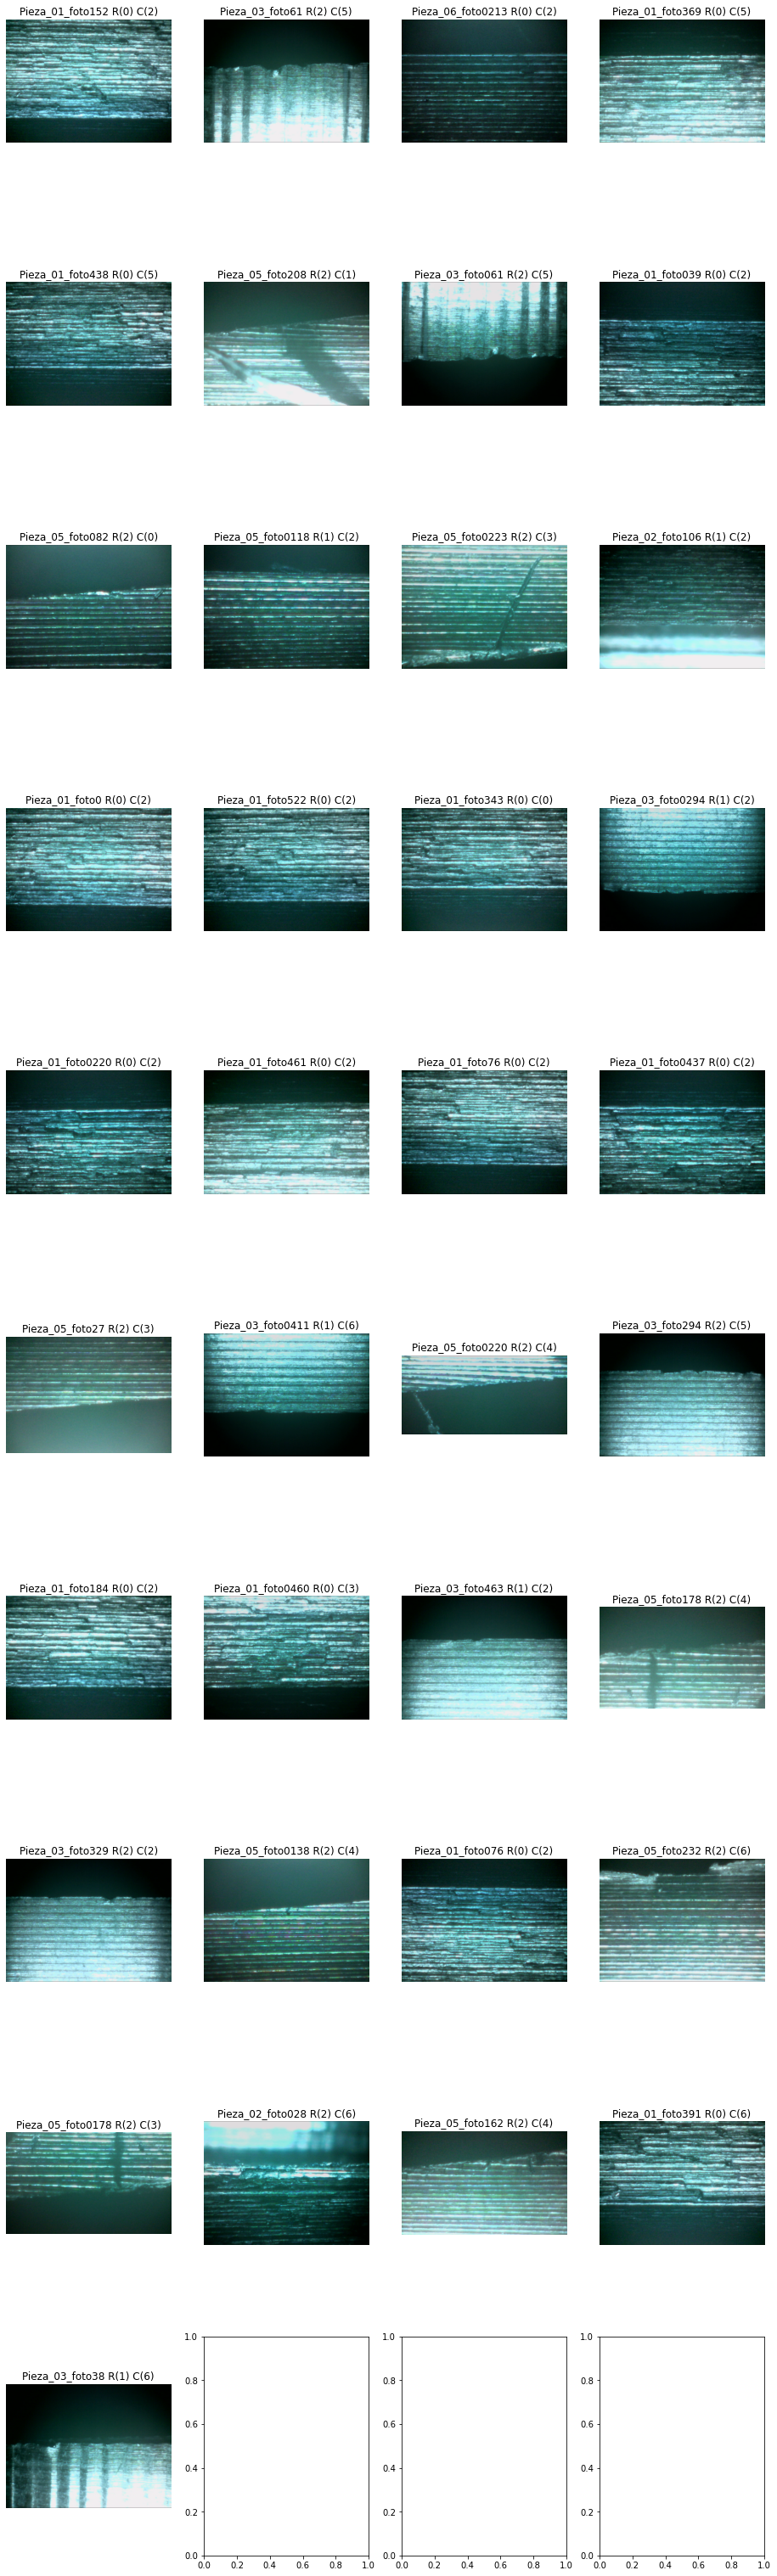

In [9]:
b = np.array(prediction).reshape(prediction.shape[0], -1)
c = np.array(y_test).reshape(y_test.shape[0], -1)
a = np.array(data.loc[X_test.index].img_name).reshape(X_test.shape[0], -1)
data_test = pd.DataFrame(np.hstack((a,b,c)), columns=['img_name', 'prediction', 'real'])
fig, axs = plt.subplots(int(prediction.shape[0]/4)+1,4, figsize=(16,56))
index = 0
for index, row in data_test.iterrows():
    image = cv2.imread('final_photos/'+row['img_name']+'.jpg')
    axs[int(index/4)][index%4].imshow(image)
    axs[int(index/4)][index%4].title.set_text(row['img_name']+' R('+str(row['real'])+') C('+str(row['prediction'])+')')
    axs[int(index/4)][index%4].axis('off')
    index +=1

k 34.3 % of the dataset
S 36.1 % of the dataset
B 29.6 % of the dataset


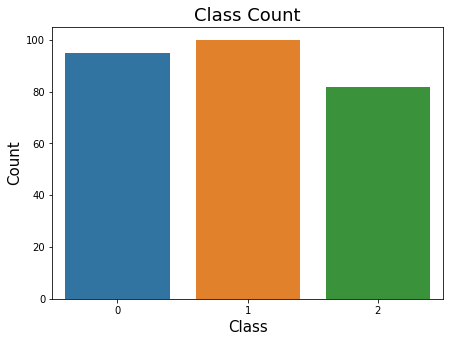

In [48]:
import seaborn as sns
# The classes are heavily skewed we need to solve this issue later.
print('k', round(data['category'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('S', round(data['category'].value_counts()[1]/len(data) * 100,2), '% of the dataset')
print('B', round(data['category'].value_counts()[2]/len(data) * 100,2), '% of the dataset')

plt.figure(figsize=(7,5))
sns.countplot(data['category'])
plt.title("Class Count", fontsize=18)
plt.xlabel("Class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

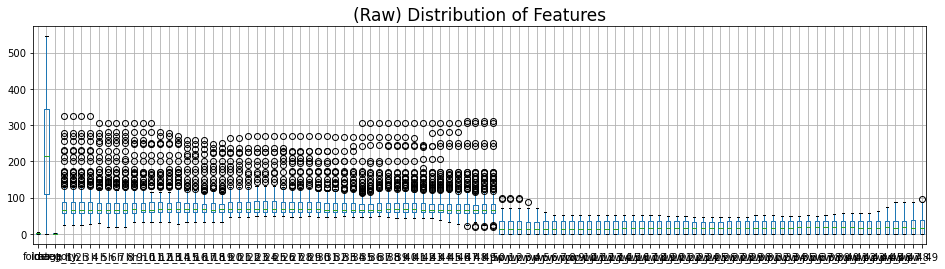

In [11]:
plt.figure(figsize=(16,4))
data.iloc[:,:-1].boxplot()
plt.title('(Raw) Distribution of Features', fontsize=17)
plt.show()

In [12]:
size_m = sections_width
X_values = data[['h_'+str(i) for i in range(1,size_m+1)]]
y_values = data[['category']]
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
# Class balance in test group
print("TEST GROUP")
print('Size:',y_test.count())
print("K percentage:",round(y_test['category'].value_counts()[0]/len(y_test) * 100,2))
print("S percentage:",round(y_test['category'].value_counts()[1]/len(y_test) * 100,2))
print("B percentage:",round(y_test['category'].value_counts()[2]/len(y_test) * 100,2))

# Class balance in train group
print("\nTRAIN GROUP")
print('Size:',y_train.count())
print("K percentage:",round(y_train['category'].value_counts()[0]/len(y_train) * 100,2))
print("S percentage:",round(y_train['category'].value_counts()[1]/len(y_train) * 100,2))
print("B percentage:",round(y_train['category'].value_counts()[2]/len(y_train) * 100,2))

TEST GROUP
Size: category    37
dtype: int64
K percentage: 43.24
S percentage: 16.22
B percentage: 40.54

TRAIN GROUP
Size: category    146
dtype: int64
K percentage: 47.26
S percentage: 22.6
B percentage: 30.14


[0.8115987743330931, 0.7876712328767124, 0.585135135135135, 0.5945945945945946]


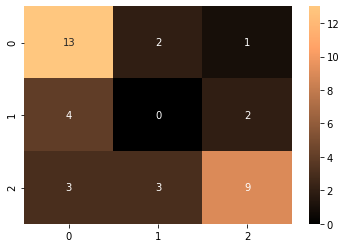

In [13]:
kmeans = KNeighborsClassifier(n_neighbors=3)#SVC(C=5, class_weight='balanced')#
kmeans.fit(X_train, y_train.values.ravel())
y_predict = kmeans.predict(X_train)
precision_train = (precision_score(y_train, y_predict, average='weighted'))
recall_train= (recall_score(y_train, y_predict, average='weighted'))
y_predict = kmeans.predict(X_test)
precision_test = (precision_score(y_test, y_predict, average='weighted'))
recall_test = (recall_score(y_test, y_predict, average='weighted'))
data_row= [ precision_train, recall_train,precision_test,recall_test]
print(data_row)

# Confusion matrix
conf_matrix = confusion_matrix(y_test.values.ravel(),y_predict)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

In [14]:
data.describe()

,folder,image,category,h_1,h_2,h_3,h_4,h_5,h_6,h_7,...,pw_41,pw_42,pw_43,pw_44,pw_45,pw_46,pw_47,pw_48,pw_49,pw_50
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,...,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,2.409836,231.890710,0.857923,82.726776,82.726776,82.683060,82.863388,83.109290,83.147541,83.191257,...,18.341772,18.157265,18.342997,18.369252,18.420310,18.563899,18.864399,19.238206,19.646467,19.655619
std,1.600588,153.226289,0.878016,45.913939,45.913939,45.925263,45.763702,45.461722,45.276381,44.994524,...,17.897267,17.876772,18.117467,18.252106,18.428100,18.705102,19.039504,19.304432,20.092456,20.077215
min,1.000000,0.000000,0.000000,24.000000,24.000000,24.000000,27.000000,31.000000,19.000000,19.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,109.000000,0.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,216.000000,1.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,...,18.518519,16.339869,17.361111,17.361111,18.248175,17.482517,18.796992,17.482517,17.482517,17.482517
75%,3.000000,345.000000,2.000000,87.500000,87.500000,87.500000,87.000000,86.000000,86.000000,86.500000,...,36.764706,36.231884,36.764706,36.764706,36.498295,36.231884,35.714286,37.313433,37.313433,37.313433
max,6.000000,545.000000,2.000000,324.000000,324.000000,324.000000,324.000000,307.000000,307.000000,307.000000,...,56.818182,56.818182,56.818182,62.500000,75.757576,89.142857,88.000000,88.000000,96.160000,96.000000


In [15]:
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

data[['h_'+str(i) for i in range(1,size_m+1)]] = rob_scaler.fit_transform(data[['h_'+str(i) for i in range(1,size_m+1)]].values)

In [16]:
data.describe()

,folder,image,category,h_1,h_2,h_3,h_4,h_5,h_6,h_7,...,pw_41,pw_42,pw_43,pw_44,pw_45,pw_46,pw_47,pw_48,pw_49,pw_50
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,...,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,2.409836,231.890710,0.857923,0.567009,0.567009,0.565527,0.581496,0.611046,0.612412,0.613973,...,18.341772,18.157265,18.342997,18.369252,18.420310,18.563899,18.864399,19.238206,19.646467,19.655619
std,1.600588,153.226289,0.878016,1.556405,1.556405,1.556789,1.578059,1.623633,1.617014,1.606947,...,17.897267,17.876772,18.117467,18.252106,18.428100,18.705102,19.039504,19.304432,20.092456,20.077215
min,1.000000,0.000000,0.000000,-1.423729,-1.423729,-1.423729,-1.344828,-1.250000,-1.678571,-1.678571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,109.000000,0.000000,-0.271186,-0.271186,-0.271186,-0.275862,-0.285714,-0.285714,-0.267857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,216.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,18.518519,16.339869,17.361111,17.361111,18.248175,17.482517,18.796992,17.482517,17.482517,17.482517
75%,3.000000,345.000000,2.000000,0.728814,0.728814,0.728814,0.724138,0.714286,0.714286,0.732143,...,36.764706,36.231884,36.764706,36.764706,36.498295,36.231884,35.714286,37.313433,37.313433,37.313433
max,6.000000,545.000000,2.000000,8.745763,8.745763,8.745763,8.896552,8.607143,8.607143,8.607143,...,56.818182,56.818182,56.818182,62.500000,75.757576,89.142857,88.000000,88.000000,96.160000,96.000000


[0.717898341744773, 0.7054794520547946, 0.5923423423423423, 0.6216216216216216]


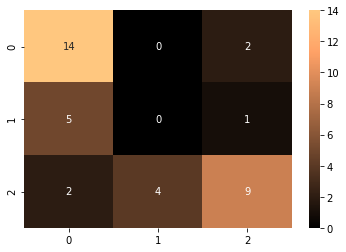

In [17]:
kmeans = KNeighborsClassifier(n_neighbors=5, p=2)#SVC(C=5, class_weight='balanced')#
kmeans.fit(X_train, y_train.values.ravel())
y_predict = kmeans.predict(X_train)
precision_train = (precision_score(y_train, y_predict, average='weighted'))
recall_train= (recall_score(y_train, y_predict, average='weighted'))
y_predict = kmeans.predict(X_test)
precision_test = (precision_score(y_test, y_predict, average='weighted'))
recall_test = (recall_score(y_test, y_predict, average='weighted'))
data_row= [ precision_train, recall_train,precision_test,recall_test]
print(data_row)

# Confusion matrix
conf_matrix = confusion_matrix(y_test.values.ravel(),y_predict)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

# PRUEBAS FINALES

(260, 104)
[0.8010736670323174, 0.7740384615384616, 0.8012820512820512, 0.7692307692307693]


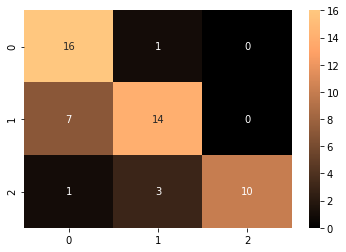

In [58]:
from sklearn.preprocessing import normalize
file_name = 'info_h_50'
sections_width = 50
data = prepare_data(file_name, data_category)
size_m = sections_width
columns = ['h_'+str(a) for a in range(1,size_m+1)] #+ ['pw_'+str(a) for a in range(1,size_m+1)]
X_values = data[columns]
y_values = data[['category']]
print(data.shape)

data_np = np.array([])
for i in range(0,5):
    X_values_b = data[['pw_'+str(a) for a in range(1+(10*i),(10*(i+1)+1))]]
    b = np.array(X_values_b.mean(axis=1)).reshape(X_values_b.shape[0], -1)
    c = np.array(X_values_b.std(axis=1)).reshape(X_values_b.shape[0], -1)
    d = np.array(X_values_b.min(axis=1)).reshape(X_values_b.shape[0], -1)
    e = np.array(X_values_b.max(axis=1)).reshape(X_values_b.shape[0], -1)
    f = np.array(X_values_b.median(axis=1)).reshape(X_values_b.shape[0], -1)
    data_np = np.hstack((b,c,d,e))
"""
b = np.array(X_values_b.mean(axis=1)).reshape(X_values_b.shape[0], -1)
c = np.array(X_values_b.std(axis=1)).reshape(X_values_b.shape[0], -1)
d = np.array(X_values_b.min(axis=1)).reshape(X_values_b.shape[0], -1)
e = np.array(X_values_b.max(axis=1)).reshape(X_values_b.shape[0], -1)
f = np.array(X_values_b.median(axis=1)).reshape(X_values_b.shape[0], -1)
g = np.array(X_values_b.mode(axis=1)).reshape(X_values_b.shape[0], -1)

X_values = pd.DataFrame(np.hstack((X_values,b,c,d,e)))
print(data.shape)
X_values = normalize(X_values, axis=1, norm='l1')

"""
#X_values = data_np
#order_data(data)
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
kmeans = SVC(C=3, class_weight='balanced')#KNeighborsClassifier(n_neighbors=3)#SVC(C=5, class_weight='balanced')#
kmeans.fit(X_train, y_train.values.ravel())
y_predict_train = kmeans.predict(X_train)
precision_train = (precision_score(y_train, y_predict_train, average='weighted'))
recall_train= (recall_score(y_train, y_predict_train, average='weighted'))
y_predict = kmeans.predict(X_test)
precision_test = (precision_score(y_test, y_predict, average='weighted'))
recall_test = (recall_score(y_test, y_predict, average='weighted'))
data_row= [ precision_train, recall_train,precision_test,recall_test]
print(data_row)
conf_matrix = confusion_matrix(y_test.values.ravel(),y_predict)
sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()

file_name = 'info_pw_2_20'
sections_width = int(file_name.split("_")[-2])
sections_heigth = int(file_name.split("_")[-1])
data20 = prepare_data(file_name, data_category)
size_m = sections_width*sections_heigth
X_values = data[['pw_'+str(i) for i in range(1,size_m+1)]]
y_values = data[['category']]
#order_data(data)
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)

In [ ]:
b = np.array(y_predict_train).reshape(y_predict_train.shape[0], -1)
c = np.array(y_train).reshape(y_train.shape[0], -1)
a = np.array(data.loc[y_train.index].img_name).reshape(y_train.shape[0], -1)
data_test = pd.DataFrame(np.hstack((a,b,c)), columns=['img_name', 'prediction', 'real'])
data_filtered = data_test[(data_test.prediction - data_test.real) !=0]
data_filtered = data_filtered.sort_values(by=['img_name'])
fig, axs = plt.subplots(int(data_filtered.shape[0]/2)+1,2, figsize=(16,30))
index_plot = 0
for index, row in data_filtered.iterrows():
    image = cv2.imread('rustico_test/'+row['img_name']+'_potential.jpg')
    axs[int(index_plot/2)][index_plot%2].imshow(image)
    axs[int(index_plot/2)][index_plot%2].title.set_text(row['img_name']+' R('+str(row['real']+1)+') C('+str(row['prediction']+1)+')')
    axs[int(index_plot/2)][index_plot%2].axis('off')
    index_plot +=1

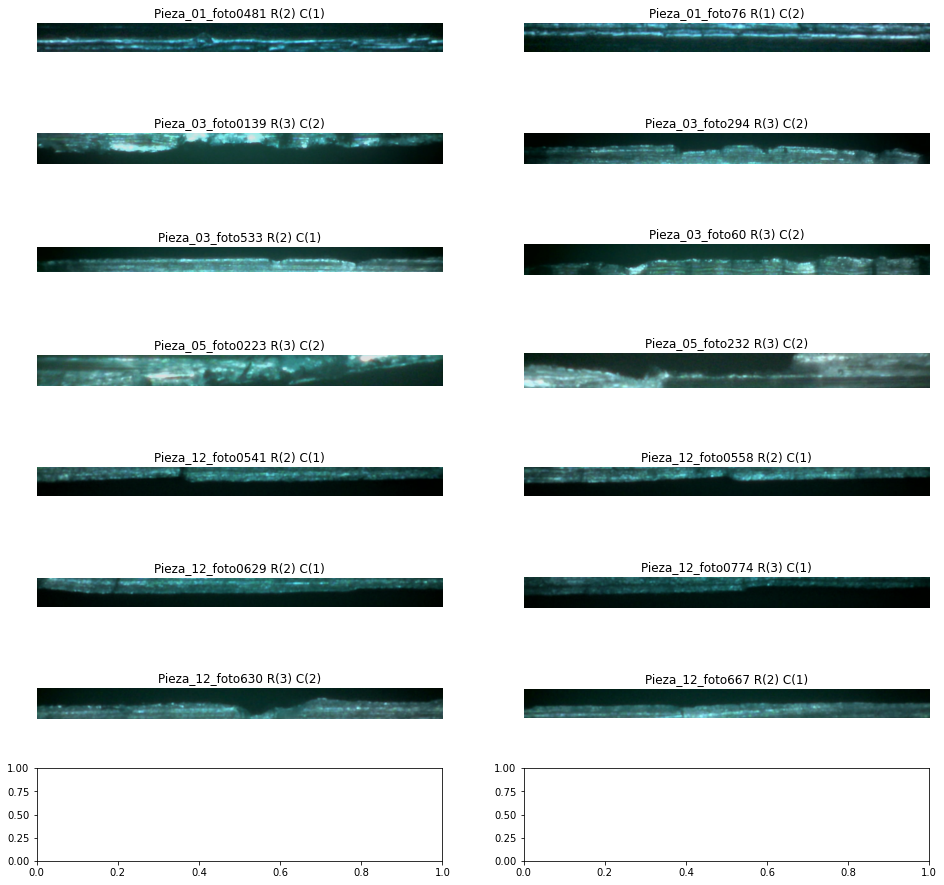

In [56]:
b = np.array(y_predict).reshape(y_predict.shape[0], -1)
c = np.array(y_test).reshape(y_test.shape[0], -1)
a = np.array(data.loc[y_test.index].img_name).reshape(y_test.shape[0], -1)
data_test = pd.DataFrame(np.hstack((a,b,c)), columns=['img_name', 'prediction', 'real'])
data_filtered = data_test[(data_test.prediction - data_test.real) !=0]
data_filtered = data_filtered.sort_values(by=['img_name'])
fig, axs = plt.subplots(int(data_filtered.shape[0]/2)+1,2, figsize=(16,16))
index_plot = 0
for index, row in data_filtered.iterrows():
    image = cv2.imread('rustico_test/'+row['img_name']+'_potential.jpg')
    axs[int(index_plot/2)][index_plot%2].imshow(image)
    axs[int(index_plot/2)][index_plot%2].title.set_text(row['img_name']+' R('+str(row['real']+1)+') C('+str(row['prediction']+1)+')')
    axs[int(index_plot/2)][index_plot%2].axis('off')
    index_plot +=1

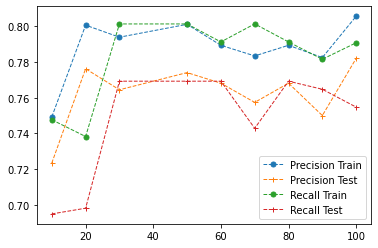

,width,data,diff_precision_recall,precision_train,recall_train,precision_test,recall_test
0,100,264,0.014867,0.805593,0.790726,0.781991,0.754717
0,50,260,0.000208,0.801074,0.801282,0.774038,0.769231
0,20,263,0.062353,0.800601,0.738247,0.776190,0.698113
0,30,260,0.007428,0.793854,0.801282,0.764423,0.769231
0,60,259,0.001881,0.789328,0.791209,0.768116,0.769231
0,80,259,0.001881,0.789328,0.791209,0.768116,0.769231
0,70,171,0.017942,0.783376,0.801319,0.757353,0.742857
0,90,170,0.000939,0.782452,0.781513,0.750000,0.764706
0,10,294,0.001579,0.749212,0.747633,0.723404,0.694915


In [83]:

widths = [10,20,30,50,60,70,80,90,100]
final_data = pd.DataFrame()
for w in range(0,len(widths)):
    info_results = []    
    file_name = 'info_h_'+str(widths[w])
    sections_width = int(file_name.split("_")[-1])
    data = prepare_data(file_name, data_category)    
    size_m = sections_width
    columns = ['h_'+str(a) for a in range(1,size_m+1)] #+ ['pw_'+str(a) for a in range(1,size_m+1)]
    X_values = data[columns]
    #X_values = normalize(X_values,axis = 1, norm='l2')
    y_values = data[['category']]
    #order_data(data)
    X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
    kmeans = SVC(C=3, class_weight='balanced') #KNeighborsClassifier(n_neighbors=3) #GaussianNB() # 
    kmeans.fit(X_train, y_train.values.ravel())
    y_predict = kmeans.predict(X_train)
    precision_train = (precision_score(y_train, y_predict, average='weighted'))
    recall_train= (recall_score(y_train, y_predict, average='weighted'))
    y_predict = kmeans.predict(X_test)
    precision_test = (precision_score(y_test, y_predict, average='weighted'))
    recall_test = (recall_score(y_test, y_predict, average='weighted'))
    data_row= [ widths[w], data.shape[0],precision_train, recall_train,precision_test,recall_test]
    info_results.append(data_row)
    info_results =pd.DataFrame(info_results, columns=['width','data','precision_train', 'precision_test', 'recall_train', 'recall_test']) 
    final_data = pd.concat([final_data, info_results])
plt.plot(final_data.width,final_data.precision_train,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Precision Train')
plt.plot(final_data.width,final_data.precision_test,marker='+',linestyle='dashed',linewidth=1,markersize=5, label='Precision Test')
plt.plot(final_data.width,final_data.recall_train,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Recall Train')
plt.plot(final_data.width,final_data.recall_test,marker='+',linestyle='dashed',linewidth=1,markersize=5, label='Recall Test')
#plt.title.set_text(str(widths[w])+' width sections')
#plt.set_ylim([0.53, 0.85])
plt.legend()
plt.show()
final_data['diff_precision_recall'] = abs(final_data['precision_train'] - final_data['recall_train'])
final_data = final_data.reindex(['width', 'data','diff_precision_recall','precision_train', 'recall_train', 'precision_test', 'recall_test'], axis=1)
final_data.sort_values(by=['precision_train','diff_precision_recall', 'recall_train', 'precision_test', 'recall_test'], ascending=False)

In [39]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

file_name = 'info_h_30'
sections_width = int(file_name.split("_")[-1])
data = prepare_data(file_name, data_category)
size_m = sections_width
X_values = data[['h_'+str(a) for a in range(1,size_m+1)]]
y_values = data[['category']]
#order_data(data)
X_values = normalize(X_values,axis = 1, norm='l2')
X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)

#parameters = {'n_neighbors':range(3,7), 'p':[1,2,4]}
parameters = {'C':range(1,10), 'class_weight':['balanced', None]}
svc = SVC()#KNeighborsClassifier()
clf = GridSearchCV(svc, parameters, scoring='recall_weighted', cv=15)
clf.fit(X_values, y_values.values.ravel())


data = pd.DataFrame(clf.cv_results_)
data.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
13,0.009042,0.000441,0.001131,0.000339,7,None,"{'C': 7, 'class_weight': None}",0.652174,0.652174,0.454545,...,0.590909,0.772727,0.363636,0.636364,0.727273,0.772727,0.636364,0.602108,0.113620,1
6,0.009441,0.000801,0.001063,0.000249,4,balanced,"{'C': 4, 'class_weight': 'balanced'}",0.652174,0.652174,0.409091,...,0.636364,0.772727,0.409091,0.636364,0.590909,0.772727,0.636364,0.599078,0.108298,2
8,0.009241,0.000441,0.001330,0.000470,5,balanced,"{'C': 5, 'class_weight': 'balanced'}",0.652174,0.652174,0.409091,...,0.636364,0.772727,0.363636,0.636364,0.545455,0.772727,0.636364,0.596047,0.111613,3
11,0.008909,0.000249,0.001330,0.000470,6,None,"{'C': 6, 'class_weight': None}",0.652174,0.652174,0.454545,...,0.545455,0.772727,0.409091,0.636364,0.681818,0.772727,0.636364,0.596047,0.107847,3
4,0.009472,0.000643,0.001398,0.000492,3,balanced,"{'C': 3, 'class_weight': 'balanced'}",0.652174,0.565217,0.454545,...,0.590909,0.727273,0.454545,0.681818,0.590909,0.772727,0.636364,0.593281,0.096848,5
15,0.009175,0.000399,0.001463,0.000498,8,None,"{'C': 8, 'class_weight': None}",0.652174,0.652174,0.454545,...,0.545455,0.772727,0.363636,0.636364,0.727273,0.772727,0.590909,0.593017,0.115947,6
17,0.009240,0.000567,0.001331,0.000470,9,None,"{'C': 9, 'class_weight': None}",0.652174,0.652174,0.454545,...,0.545455,0.772727,0.363636,0.636364,0.772727,0.818182,0.590909,0.593017,0.125090,7
10,0.009508,0.000498,0.001064,0.000249,6,balanced,"{'C': 6, 'class_weight': 'balanced'}",0.608696,0.652174,0.409091,...,0.590909,0.772727,0.409091,0.636364,0.545455,0.772727,0.636364,0.590119,0.104950,8
2,0.008316,0.000467,0.001136,0.000331,2,balanced,"{'C': 2, 'class_weight': 'balanced'}",0.652174,0.608696,0.454545,...,0.545455,0.727273,0.500000,0.681818,0.545455,0.772727,0.590909,0.590119,0.107543,8
12,0.009507,0.000498,0.001330,0.000470,7,balanced,"{'C': 7, 'class_weight': 'balanced'}",0.608696,0.652174,0.409091,...,0.590909,0.772727,0.454545,0.636364,0.545455,0.772727,0.636364,0.590119,0.103629,10


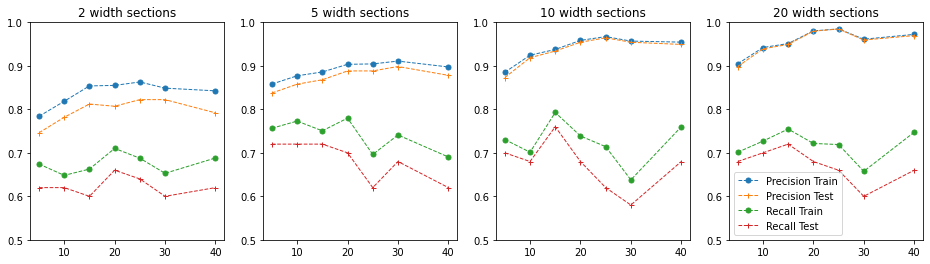

,width,range,diff_precision_recall,precision_train,recall_train,precision_test,recall_test
4,20,25,0.265975,0.985023,0.719048,0.984772,0.66
3,20,20,0.258767,0.980350,0.721583,0.979695,0.68
6,20,40,0.224942,0.972355,0.747413,0.969543,0.66
4,10,25,0.253015,0.967197,0.714182,0.964467,0.62
5,20,30,0.303740,0.961240,0.657500,0.959391,0.60
3,10,20,0.219856,0.958540,0.738684,0.954315,0.68
5,10,30,0.319125,0.956932,0.637807,0.954315,0.58
6,10,40,0.194527,0.954527,0.760000,0.949239,0.68
2,20,15,0.196505,0.951224,0.754719,0.949239,0.72
1,20,10,0.215229,0.942123,0.726895,0.939086,0.70


In [12]:
final_data = pd.DataFrame()
fig, axs = plt.subplots(1,4, figsize=(16,4))
widths = [2,5,10,20]
sections = [5,10,15,20, 25,30,40]
for w in range(0,len(widths)):
    info_results = []
    for i in sections:
        file_name = 'info_pw_'+str(widths[w])+'_'+str(i)
        sections_width = int(file_name.split("_")[-2])
        sections_heigth = int(file_name.split("_")[-1])
        data = prepare_data(file_name, data_category)
        size_m = sections_width*sections_heigth
        X_values = data[['pw_'+str(a) for a in range(1,size_m+1)]]
        y_values = data[['category']]
        #order_data(data)
        X_train, X_test, y_train, y_test = train_test_split(X_values, y_values, test_size=0.2, random_state=seed)
        dummy_clf = SVC(C=5, class_weight='balanced')
        dummy_clf.fit(X_train, y_train.values.ravel())
        y_predict = dummy_clf.predict(X_train)
        precision_train = (precision_score(y_train, y_predict, average='weighted'))
        recall_train= (recall_score(y_train, y_predict, average='weighted'))
        y_predict = dummy_clf.predict(X_test)
        precision_test = (precision_score(y_test, y_predict, average='weighted'))
        recall_test = (recall_score(y_test, y_predict, average='weighted'))
        data_row= [ i, precision_train, recall_train,precision_test,recall_test]
        info_results.append(data_row)
    info_results =pd.DataFrame(info_results, columns=['range', 'precision_train', 'precision_test', 'recall_train', 'recall_test'])
    
    axs[w].plot(info_results.range,info_results.precision_train,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Precision Train')
    axs[w].plot(info_results.range,info_results.precision_test,marker='+',linestyle='dashed',linewidth=1,markersize=5, label='Precision Test')
    axs[w].plot(info_results.range,info_results.recall_train,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Recall Train')
    axs[w].plot(info_results.range,info_results.recall_test,marker='+',linestyle='dashed',linewidth=1,markersize=5, label='Recall Test')
    axs[w].title.set_text(str(widths[w])+' width sections')
    axs[w].set_ylim([0.5, 1])
    info_results['width'] = widths[w]
    final_data = pd.concat([final_data, info_results])
plt.legend()
plt.show()

final_data['diff_precision_recall'] = abs(final_data['precision_train'] - final_data['recall_train'])
final_data = final_data.reindex(['width','range','diff_precision_recall','precision_train', 'recall_train', 'precision_test', 'recall_test'], axis=1)
final_data.sort_values(by=['precision_train','diff_precision_recall', 'recall_train', 'precision_test', 'recall_test'], ascending=False)

y_predict = kmeans.predict(X_train)
print(confusion_matrix(y_train, y_predict))
print(classification_report(y_train, y_predict, digits=3, target_names=['K', 'S', 'B']))
print(precision_score(y_train, y_predict, average='weighted'))

y_predict = kmeans.predict(X_test)
print(confusion_matrix(y_test, y_predict))
#plot_confusion_matrix(kmeans, X_test, y_test) 
print(classification_report(y_test, y_predict, digits=3, target_names=['K', 'S', 'B']))

In [15]:
k_values = range(3,22)
precision = []
recall = []
f1 = []
acc= []
for k in k_values:
    kmeans = KNeighborsClassifier(n_neighbors=k)
    kmeans.fit(X_train, y_train.values.ravel())
    y_pred = kmeans.predict(X_test)
    
    precision.append(precision_score(y_test, y_pred, average='micro'))
    recall.append(recall_score(y_test, y_pred, average='micro'))
    f1.append(f1_score(y_test, y_pred, average='micro'))
    
    acc.append(accuracy_score(y_test.values.ravel(), y_pred))
print(acc)

[0.6363636363636364, 0.6590909090909091, 0.6136363636363636, 0.6136363636363636, 0.6136363636363636, 0.6136363636363636, 0.6590909090909091, 0.6590909090909091, 0.6136363636363636, 0.5909090909090909, 0.6136363636363636, 0.6363636363636364, 0.6136363636363636, 0.6363636363636364, 0.6818181818181818, 0.6363636363636364, 0.6363636363636364, 0.6136363636363636, 0.6363636363636364]


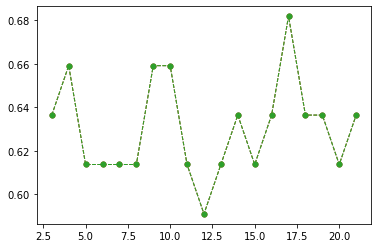

In [16]:

plt.plot(k_values,precision,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Precision')
plt.plot(k_values,recall,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='Recall')
plt.plot(k_values,f1,marker='o',linestyle='dashed',linewidth=1,markersize=5, label='F1')

#plt.plot(k_values,acc,marker='o',linestyle='dashed',linewidth=1,markersize=5, label="Accuracy")
plt.show()


In [ ]:
import numpy as np
from sklearn.dummy import DummyClassifier
X = np.array([-1, 1, 1, 1])
y = np.array([0, 1, 1, 1])
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

y_predict = dummy_clf.predict(X_test)

print(accuracy_score(y_test.values.ravel(), y_predict))

data_categories = pd.read_csv('info_data.csv', delimiter=';', decimal=",") 
data_categories['category'] =data_categories.apply(lambda row: 3 if (row['Potential section']==1) else 0 if (row.K==1) else 1 if (row.S==1) else 2 if (row.B==1) else 3, axis=1)

In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_values)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_values], axis = 1)

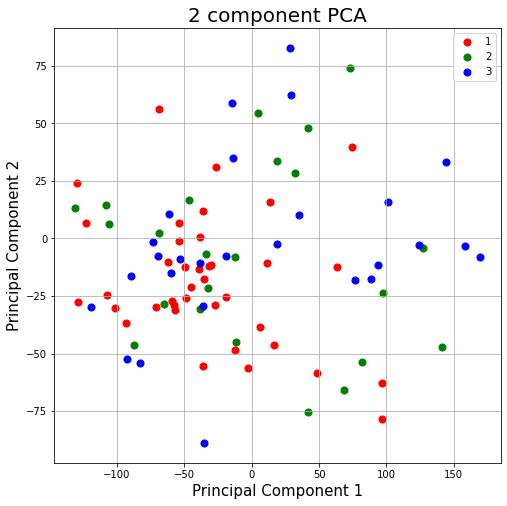

In [55]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,2,3]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['category'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
from sklearn.svm import SVC
dummy_clf = SVC(kernel='poly', gamma='auto')
dummy_clf.fit(principalDf[['principal component 1', 'principal component 2']], y_values)

y_predict = dummy_clf.predict(principalDf)
print(classification_report(y_train, y_predict, digits=3, target_names=['K', 'S', 'B']))

y_predict = dummy_clf.predict(X_test)
print(classification_report(y_test, y_predict, digits=3, target_names=['K', 'S', 'B']))

c:\users\virgi\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [10]:
data.sort_values(by=['RUSTICO+houghLine'])
dataK = data[data['K']==1]
dataS = data[data['S']==1]
dataB = data[data['B']==1]

KeyError: 'RUSTICO+houghLine'

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(dataK.index, dataK['RUSTICO+houghLine'], 'o', color='red')
plt.plot(dataS.index, dataS['RUSTICO+houghLine'], 'o', color='blue')
plt.plot(dataB.index, dataB['RUSTICO+houghLine'], 'o', color='green')

In [ ]:
data.sort_values(by=['SOCO2020'])
dataK = data[data['K']==1]
dataS = data[data['S']==1]
dataB = data[data['B']==1]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(dataK.index, dataK['SOCO2020'], 'o', color='red')
plt.plot(dataS.index, dataS['SOCO2020'], 'o', color='blue')
plt.plot(dataB.index, dataB['SOCO2020'], 'o', color='green')

In [ ]:
X = np.array(data['RUSTICO+houghLine'])
X = X.reshape((X.shape[0],1))
y = np.array(data['category'])

In [ ]:
def total_internal_ss(X, centers, clusters):
    total = 0
    for i in range(0,clusters.shape[0]):
        dist_squared = sum([(a_i - b_i)**2 for a_i,b_i in zip(X[i], centers[clusters[i]])])
        total += dist_squared ** 2
    return total

In [ ]:
data_x = range(3,15)
data_y = []
for k in data_x:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    centers = kmeans.cluster_centers_
    clusters = kmeans.labels_
    total = total_internal_ss(X,centers, clusters)
    data_y.append(total)
print(data_y)

In [ ]:
plt.plot(data_x,data_y, marker='o')
plt.xlabel('k')
plt.ylabel('Total sum of squares')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=9, random_state=0).fit(X)
centers = kmeans.cluster_centers_
clusters = kmeans.labels_

In [ ]:
data_values = []
data_type = []
for i in range(0,centers.shape[0]):
    total = [0,0,0]
    for j in range(0,clusters.shape[0]):
        if (clusters[j]==i):
            total[y[j]-1] += 1
    data_values.append(total)
    data_type.append(total.index(max(total)))
print(data_values)
print(data_type)

In [ ]:
data.sort_values(by=['RUSTICO+houghLine']) 
data = data.reset_index(drop=True)
dataK = data[data['K']==1]
dataS = data[data['S']==1]
dataB = data[data['B']==1]

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(dataK.index, dataK['RUSTICO+houghLine'], 'o', color='red')
plt.plot(dataS.index, dataS['RUSTICO+houghLine'], 'o', color='blue')
plt.plot(dataB.index, dataB['RUSTICO+houghLine'], 'o', color='orange')
for i in range(0,centers.shape[0]):
    plt.axhline(y=centers[i])